In [1]:
import git
repo = git.Repo('.', search_parent_directories=True)
repo_loc = repo.working_tree_dir

import os
import sys
from pathlib import Path

sys.path.append(repo_loc)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

from src.covid19_plot_func import plot_state_num, plot_death_cause, plot_death_cumsum, plot_death_icu_rate
from src.covid19_model import run_model, run_multiple

from src.covid19_region_attr import create_region
from src import conf_helper as cf

# Set parameters

In [2]:
config_model_param_file = 'model_param_v1.yaml'
model_config = cf.CovidConf(project_dir=repo_loc, config_file=config_model_param_file)
# init_P_matrix = get_prob_matrix(model_config)

In [3]:
config_region_file = 'wuhan_20200412.yaml'
# config = cf.CovidConf(project_dir=repo_loc, config_file=config_file, config_dir='config/region_model')
region = create_region(config_region_file)

In [4]:
###########################################
# Choose the region to test the model with
###########################################
n_days = len(region.daily_case) + 50

##### Setting hopsital beds, ICU and ventilator numbers #####

t_hosp_bed = 2000 # Assuming there is enough number of hospital beds (not ICU beds)

# Set the t_icu number
# Can set it to region.t_icu_est (estimated available ICU avaiable for the region), region.t_icu_ade (adequate ICU number for the region) or any numbers one wants
t_icu = region.t_icu_est

# Initial number of ICU beds. If t_icu_portion is a list, then will run with multiple tests with different t_icu_portion
# t_icu_portion = [1/10, 1/5, 1/2, 1]
# t_icu_portion = np.arange(0.0, 1.01, 0.01)
t_icu_portion = ""


if t_icu_portion !="":
    t_icu = (np.array(t_icu_portion)*t_icu).round()
else:
    t_icu = [t_icu]
t_vent = (np.array(t_icu)*0.6).round() # Initial number of ventilators

# Run model

In [5]:
list_df_infected = []
list_df_death_cause = []

print("Run model for region: ", region.region_name)
list_df_infected, list_df_death_cause = run_multiple(region.daily_case, region.pop_ratio, n_days, t_hosp_bed, t_icu, t_vent, model_config) # TODO, remove P_matrix

Run model for region:  Wuhan
t_icu:  1468.0
Running model for Day 0...
Running model for Day 10...
Running model for Day 20...
Running model for Day 30...
Running model for Day 40...
Running model for Day 50...
Running model for Day 60...
Running model for Day 70...
Running model for Day 80...
Running model for Day 90...
Running model for Day 100...
Running model for Day 110...
Running model for Day 120...
Running model for Day 130...
Finished running model for t_icu value of 1468



## Plotting

#### Number of patients in different state plot (plot_state_num)

In [6]:
from src import covid19_plot_func
reload(covid19_plot_func)
from src.covid19_plot_func import plot_state_num, plot_death_cause, plot_death_cumsum, plot_death_icu_rate

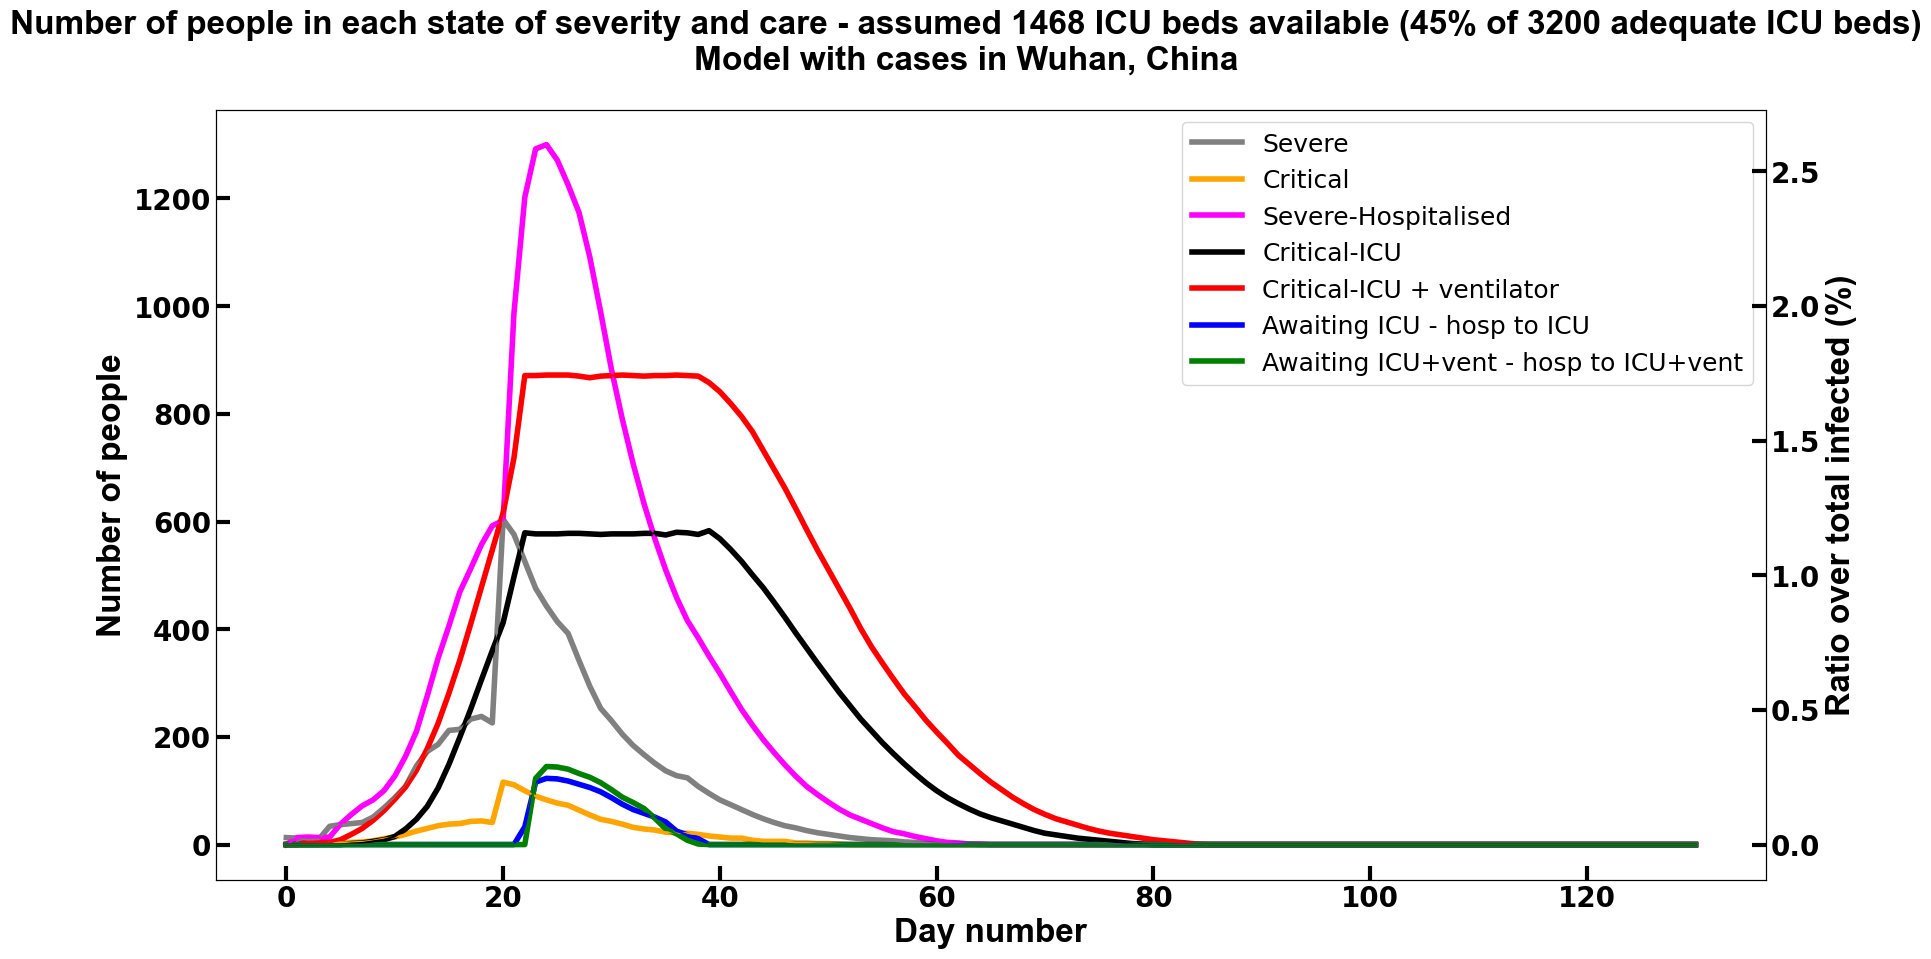

In [7]:
df_infected = list_df_infected[0]
plot_state_num(df_infected, region.daily_case.sum(), region.get_plot_title('plot_state_num', t_icu[0]))

### Number of deaths due to different causes over time

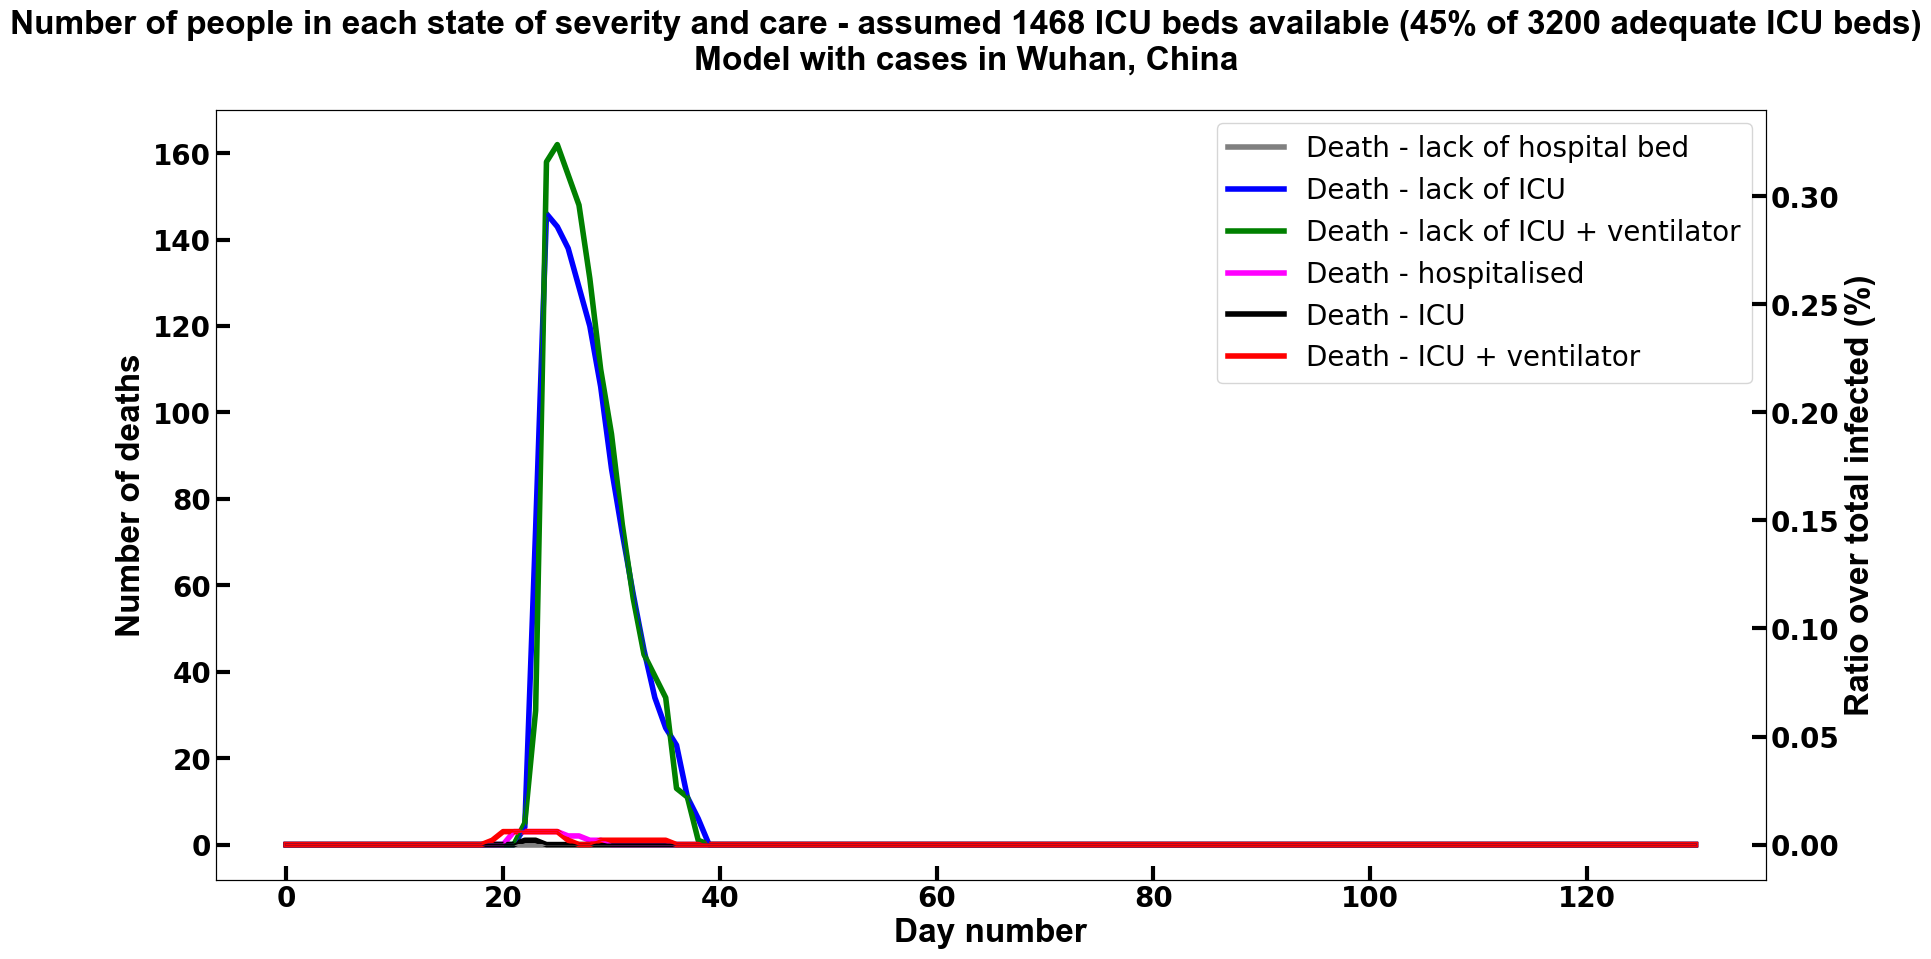

In [8]:
df_death_cause = list_df_death_cause[0]
plot_death_cause(df_death_cause, region.daily_case.sum(), region.get_plot_title('plot_death_acc', t_icu[0]))

### Accumulated number of deaths due to different cuases over time

(<Figure size 2000x1000 with 2 Axes>,
 <Axes: xlabel='Day number', ylabel='Number of deaths'>,
 <Axes: ylabel='Ratio over total infected (%)'>)

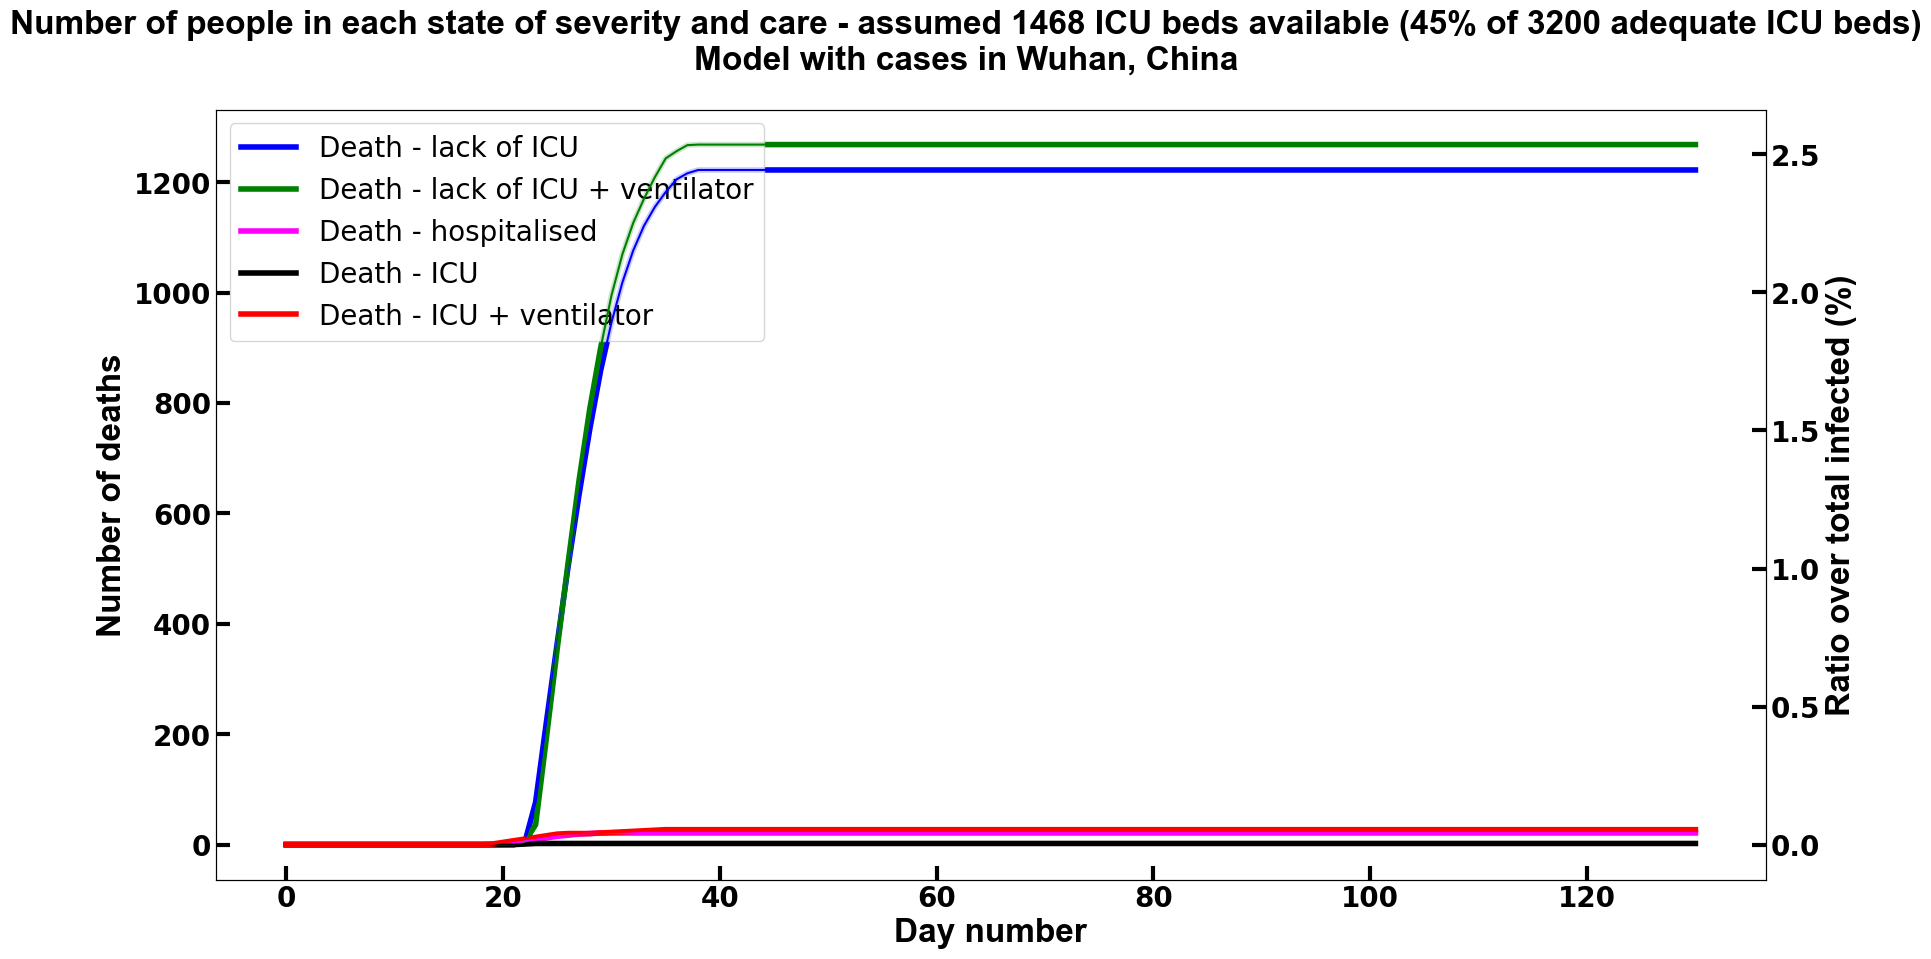

In [9]:
plot_death_cumsum(df_death_cause, region.daily_case.sum(), region.get_plot_title('plot_death_acc', t_icu[0]))